In [ ]:
pip install gym

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.animation as animation
import seaborn as sns
import random
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import preprocessing
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDRegressor
sns.set()
import gym
import time
import random
sns.set()

In [ ]:

env_name = "MountainCar-v0"
env = gym.make(env_name)
n_states = 40
episodes = 10
initial_lr = 1.0
min_lr = 0.005
gamma = 0.99
max_stps = 300
epsilon = 0.05
J = 20
actions = range(env.action_space.n)
low = env.observation_space.low
high = env.observation_space.high

In [ ]:
env_name = "MountainCar-v0"
env = gym.make(env_name)
obs = env.reset()
env = env.unwrapped
env.seed()
np.random.seed(0)
# Quantize the states
def discretization(env, obs):
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_den = (env_high - env_low) / n_states
    pos_den = env_den[0]
    vel_den = env_den[1]
    pos_high = env_high[0]
    pos_low = env_low[0]
    vel_high = env_high[1]
    vel_low = env_low[1]
    pos_scaled = int((obs[0] - pos_low)/pos_den)
    vel_scaled = int((obs[1] - vel_low)/vel_den)
    return pos_scaled, vel_scaled

q_table = np.zeros((n_states, n_states, env.action_space.n))
total_steps = 0
step_count = []
for episode in range(episodes):
    
    start_time = time.time()
    obs = env.reset()
    total_reward = 0
    alpha = max(min_lr, initial_lr*(gamma**(episode//100)))
    steps = 0
    while True:
        pos, vel = discretization(env, obs)
        if np.random.uniform(low=0, high=1) < epsilon:
            a = np.random.choice(env.action_space.n)
        else:
            a = np.argmax(q_table[pos][vel])
        obs, reward, terminate,_ = env.step(a)
        total_reward += abs(obs[0]+0.5)
        pos_, vel_ = discretization(env, obs)
        # Q function update
        q_table[pos][vel][a] = (1-alpha)*q_table[pos][vel][a] + alpha*(reward+gamma*np.max(q_table[pos_][vel_]))
        steps += 1
        if terminate:
            step_count.append(steps)
            elapsed_time = time.time() - start_time
            break

# Run only in Jupyter:
# while True:
#   env.render()

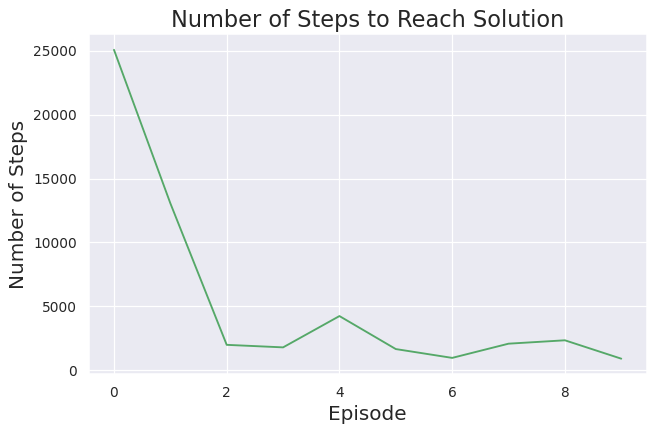

In [ ]:
plt.figure(num=None, figsize=(8, 5), dpi=90, facecolor='w', edgecolor='k')
plt.plot(range(len(step_count)), step_count, color='g')
plt.xlabel("Episode", fontsize=16)
plt.ylabel("Number of Steps", fontsize=16)
plt.title("Number of Steps to Reach Solution", fontsize=18);


In [ ]:

def design_matrix(X, N, J):
    # J basis functions obtained by k-means clustering
    # sigma set to standard deviation of entire data
    kmeans = KMeans(n_clusters=J, random_state=0).fit(X)
    # Construct design matrix
    U = np.zeros((N, J))
    for i in range(N):
        for j in range(J):
            U[i][j] = np.linalg.norm(X[i] - kmeans.cluster_centers_[j])
    return U

X (40, 2)
U: (40, 20)
Q_Table (40, 40, 3)
W (20, 120)
yh_rbf (40, 120)


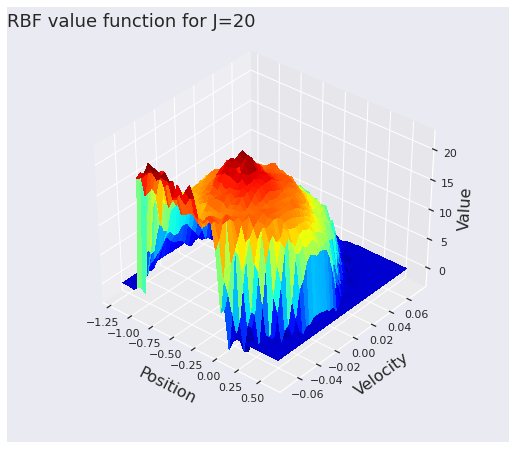

In [ ]:
pos = np.linspace(-1.2, 0.6, n_states)
vel = np.linspace(-0.07, 0.07, n_states)
X = np.dstack([pos, vel]).reshape(n_states, 2)
print("X", X.shape)
U = design_matrix(X, X.shape[0], J)
print('U:', U.shape)
print('Q_Table', q_table.shape)
# Calculating the optimal weights for the actions
w = np.dot((np.linalg.inv(np.dot(U.T, U))), U.T) @ q_table.reshape(U.shape[0], -1)
print("W", w.shape)
yh_rbf = U @ w
print('yh_rbf', yh_rbf.shape)

# Plotting obtained value function
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d', elev=40, azim=-50)
pos_grid, vel_grid = np.meshgrid(pos, vel)
Z = yh_rbf.reshape(n_states, n_states, 3)
Z = -np.max(Z, 2)
ax.plot_surface(pos_grid, vel_grid, Z, cmap=cm.jet,
                      linewidth=0, antialiased=False)
ax.set_title('RBF value function for J=' + str(J), loc='left', pad=-19.5, fontsize=18)
ax.set_xlabel('Position', fontsize=16)
ax.set_ylabel('Velocity', fontsize=16)
ax.set_zlabel('Value', fontsize=16);
ax.xaxis.labelpad=16
ax.yaxis.labelpad=16
ax.zaxis.labelpad=5
ax.dist = 12
plt.savefig("rbf2.png", format='png', dpi=1200, bbox_inches='tight')
plt.show()

In [ ]:
yh_rbf = yh_rbf.reshape(n_states, n_states, 3)
env_name = "MountainCar-v0"
env = gym.make(env_name)
obs = env.reset()
# Run only in Jupyter:
# env.render()
env = env.unwrapped
env.seed()
np.random.seed(0)
# Quantize the states
def discretization(env, obs):
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_den = (env_high - env_low) / n_states
    pos_den = env_den[0]
    vel_den = env_den[1]
    pos_high = env_high[0]
    pos_low = env_low[0]
    vel_high = env_high[1]
    vel_low = env_low[1]
    pos_scaled = int((obs[0] - pos_low)/pos_den)
    vel_scaled = int((obs[1] - vel_low)/vel_den)
    return pos_scaled, vel_scaled

total_steps = 0
step_count2 = []
for episode in range(episodes):
    start_time = time.time()
    obs = env.reset()
    total_reward = 0
    alpha = max(min_lr, initial_lr*(gamma**(episode//100)))
    steps = 0
    while True:
      # Run only in Jupyter:
      # env.render()
        pos, vel = discretization(env, obs)
        if np.random.uniform(low=0, high=1) < epsilon:
            a = np.random.choice(env.action_space.n)
        else:
            a = np.argmax(yh_rbf[pos][vel])
        obs, reward, terminate,_ = env.step(a)
        total_reward += abs(obs[0]+0.5)
        steps += 1
        if terminate:
            elapsed_time = time.time() - start_time
            step_count2.append(steps)
            break
            
# Run only in Jupyter:            
# while True:
#     env.render()

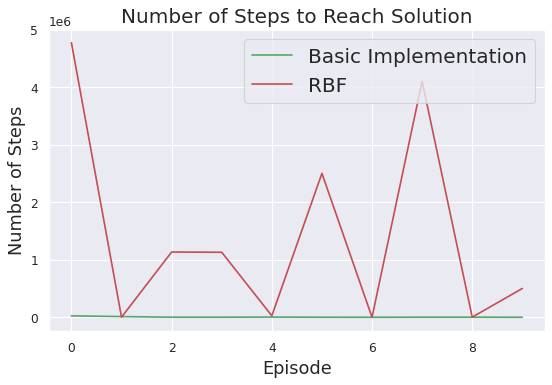

In [ ]:
plt.figure(num=None, figsize=(8, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(len(step_count)), step_count, label='Basic Implementation', color='g')
plt.plot(range(len(step_count2)), step_count2, label='RBF', color='r')
plt.legend(fontsize=18)
plt.xlabel("Episode", fontsize=16)
plt.ylabel("Number of Steps", fontsize=16)
plt.title("Number of Steps to Reach Solution", fontsize=18);
#plt.savefig("step_count.svg", format='svg', dpi=1200)

## **Second Part of the Task**

In [ ]:
env_name = "MountainCar-v0"
env = gym.make(env_name)
obs = env.reset()
xx, yy = np.meshgrid(np.linspace(low[0], high[0], J),
                     np.linspace(low[1], high[1], J))
radials = np.append(xx.reshape(xx.shape + (1,)), yy.reshape(yy.shape + (1,)), axis=2)
radials = radials.reshape((radials.size // 2, 2))
weights = np.random.random((len(actions), J** 2)) * 0.01
sigma_inverse = 1 / (high  - low) * J

def basis_function(state):
    r = sigma_inverse * (radials - state)
    return np.exp(-0.5 * np.sum(r * r, axis=1))

In [ ]:
cum_rewards, step_count3 = [], []
for episode in range(episodes):
    start_time = time.time()
    state = env.reset()
    alpha = max(min_lr, initial_lr*(gamma**(episode//100)))
    total_reward, steps = 0, 0
    while True:
        if np.random.uniform(low=0, high=1) < epsilon:
            action = np.random.choice(env.action_space.n)
        else:
            q = [np.dot(basis_function(state), weights[act]) for act in actions]
            action = np.argmax(q)
        obs, reward, terminate, _ = env.step(action)
        basis = basis_function(state)
        pi_v = reward + gamma * max([np.dot(basis_function(obs), weights[a]) for a in actions])
        gradient = np.dot(basis, (pi_v - np.dot(basis, weights[action])))
        weights[action] += alpha * gradient
        #env.render()
        total_reward += reward
        steps += 1
        state = obs
        if terminate:
            elapsed_time = time.time() - start_time
            step_count3.append(steps)
            cum_rewards.append(total_reward)
            break

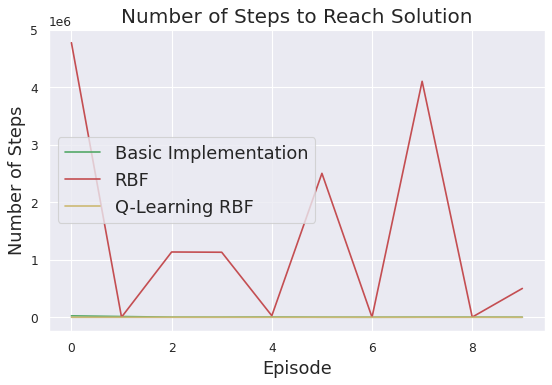

In [ ]:
plt.figure(num=None, figsize=(8, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(len(step_count)), step_count, label='Basic Implementation', color='g')
plt.plot(range(len(step_count2)), step_count2, label='RBF', color='r')
plt.plot(range(len(step_count3)), step_count3, label='Q-Learning RBF', color = 'y')
plt.legend(fontsize=16)
plt.xlabel("Episode", fontsize=16)
plt.ylabel("Number of Steps", fontsize=16)
plt.title("Number of Steps to Reach Solution", fontsize=18);


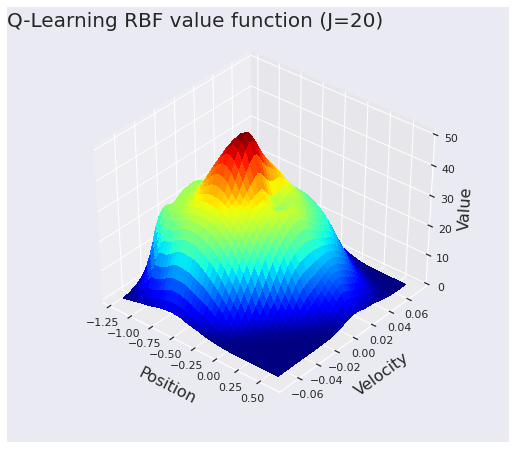

In [ ]:

fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d', elev=40, azim=-50)
xs = np.linspace(low[0], high[0], n_states)
ys = np.linspace(low[1], high[1], n_states)
X, Y = np.meshgrid(xs, ys)
states = np.append(X.reshape(X.shape + (1,)), Y.reshape(Y.shape + (1,)), axis=2)
states = states.reshape((states.shape[0]*states.shape[1], 2,))
q = np.array(list(map(lambda x: max([np.dot(basis_function(x), weights[a]) for a in actions]), states)))
Z = -q.reshape(X.shape)
ax.plot_surface(X, Y, Z, cmap=cm.jet,
                      linewidth=0, antialiased=False)
ax.set_title('Q-Learning RBF value function (J=' + str(J) + ')', loc='left', pad=-19.5, fontsize=20)
ax.set_xlabel('Position', fontsize=16)
ax.set_ylabel('Velocity', fontsize=16)
ax.set_zlabel('Value', fontsize=16);
ax.xaxis.labelpad=16
ax.yaxis.labelpad=16
ax.zaxis.labelpad=5
ax.dist = 12
plt.show()

In [ ]:
step_count, step_count2, step_count3

([25081, 13060, 1975, 1777, 4229, 1644, 953, 2066, 2331, 891],
 [4771624, 2174, 1134726, 1130364, 26731, 2501691, 705, 4101017, 3201, 501038],
 [200, 200, 200, 200, 153, 186, 164, 188, 159, 154])

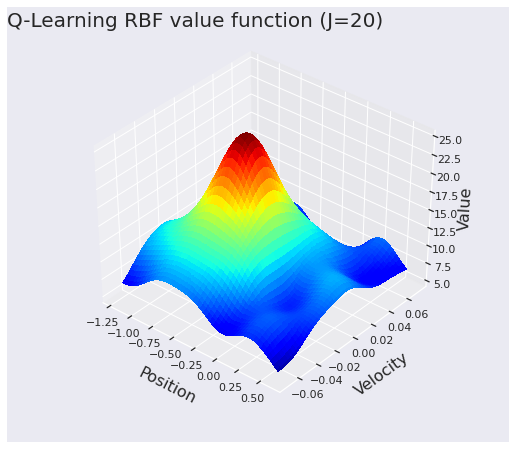

In [ ]:
env = gym.make('MountainCar-v0')
episodes = 10
J = 20
gamma = 0.99
actions = range(env.action_space.n)
low = env.observation_space.low
high = env.observation_space.high

observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = StandardScaler()
scaler.fit(observation_examples)

# Used to convert a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
design_matrix = FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=J)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=J)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=J)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=J))
        ])
example_features = design_matrix.fit_transform(scaler.transform(observation_examples))

models = []
for i in actions:
  model = SGDRegressor(learning_rate='constant')
  model.partial_fit(design_matrix.transform(scaler.transform([env.reset()])), [0])
  models.append(model)

step_count = []
for episode in range(episodes):
  obs = env.reset()
  steps = 0
  epsilon = 0.1*(0.97**episode)
  while True:
    if np.random.uniform(low=0, high=1) < epsilon:
      action = np.random.choice(env.action_space.n)
    else:
      X = design_matrix.transform(scaler.transform([obs]))
      result = np.stack([m.predict(X) for m in models]).T
      action = np.argmax(result)

    prev_obs = obs
    obs, reward, terminate,_ = env.step(action)

    # update the model
    X = design_matrix.transform(scaler.transform([obs]))
    next_state = np.stack([m.predict(X) for m in models]).T
    G = reward + gamma*np.max(next_state[0])

    X = design_matrix.transform(scaler.transform([prev_obs]))
    models[action].partial_fit(X, [G])
    steps += 1
    if terminate:
      step_count.append(steps)
      break


fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d', elev=40, azim=-50)
xs = np.linspace(low[0], high[0], J*5)
ys = np.linspace(low[1], high[1], J*5)
X, Y = np.meshgrid(xs, ys)
Z = np.apply_along_axis(lambda _: -np.max(np.stack([m.predict(design_matrix.transform(scaler.transform([_]))) for m in models]).T), 2, np.dstack([X, Y]))
ax.plot_surface(X, Y, Z, cmap=cm.jet,
                      linewidth=0, antialiased=False)
ax.set_title('Q-Learning RBF value function (J=' + str(J) + ')', loc='left', pad=-19.5, fontsize=20)
ax.set_xlabel('Position', fontsize=16)
ax.set_ylabel('Velocity', fontsize=16)
ax.set_zlabel('Value', fontsize=16);
ax.xaxis.labelpad=16
ax.yaxis.labelpad=16
ax.zaxis.labelpad=5
ax.dist = 12
plt.show()

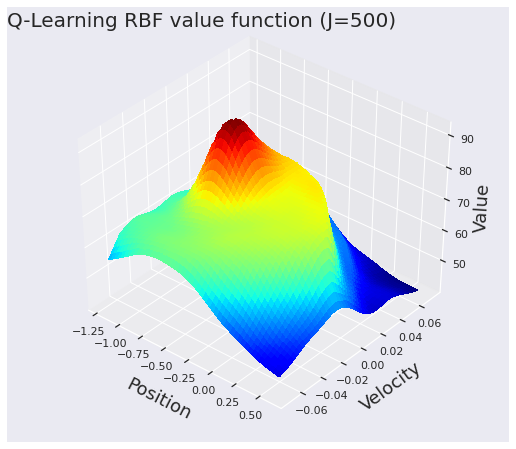

In [ ]:
env = gym.make('MountainCar-v0')
episodes = 10000
J = 500
gamma = 0.99
actions = range(env.action_space.n)
low = env.observation_space.low
high = env.observation_space.high

observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = StandardScaler()
scaler.fit(observation_examples)

# Used to convert a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
design_matrix = FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=J)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=J)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=J)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=J))
        ])
example_features = design_matrix.fit_transform(scaler.transform(observation_examples))

models = []
for i in actions:
  model = SGDRegressor(learning_rate='constant')
  model.partial_fit(design_matrix.transform(scaler.transform([env.reset()])), [0])
  models.append(model)

step_count = []
for episode in range(episodes):
  obs = env.reset()
  steps = 0
  epsilon = 0.1*(0.97**episode)
  while True:
    if np.random.uniform(low=0, high=1) < epsilon:
      action = np.random.choice(env.action_space.n)
    else:
      X = design_matrix.transform(scaler.transform([obs]))
      result = np.stack([m.predict(X) for m in models]).T
      action = np.argmax(result)

    prev_obs = obs
    obs, reward, terminate,_ = env.step(action)

    # update the model
    X = design_matrix.transform(scaler.transform([obs]))
    next_state = np.stack([m.predict(X) for m in models]).T
    G = reward + gamma*np.max(next_state[0])

    X = design_matrix.transform(scaler.transform([prev_obs]))
    models[action].partial_fit(X, [G])
    steps += 1
    if terminate:
      step_count.append(steps)
      break


fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d', elev=40, azim=-50)
xs = np.linspace(low[0], high[0], J)
ys = np.linspace(low[1], high[1], J)
X, Y = np.meshgrid(xs, ys)
Z = np.apply_along_axis(lambda _: -np.max(np.stack([m.predict(design_matrix.transform(scaler.transform([_]))) for m in models]).T), 2, np.dstack([X, Y]))
ax.plot_surface(X, Y, Z, cmap=cm.jet,
                      linewidth=0, antialiased=False)
ax.set_title('Q-Learning RBF value function (J=' + str(J) + ')', loc='left', pad=-19.5, fontsize=20)
ax.set_xlabel('Position', fontsize=18)
ax.set_ylabel('Velocity', fontsize=18)
ax.set_zlabel('Value', fontsize=18);
ax.xaxis.labelpad=15
ax.yaxis.labelpad=15
ax.zaxis.labelpad=4
ax.dist = 11
plt.savefig("q_rbf_opt.png", format='png', dpi=1200, bbox_inches='tight')
plt.show()

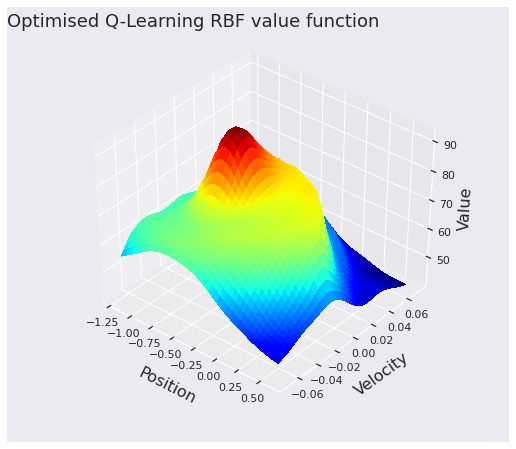

In [ ]:
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d', elev=40, azim=-50)
xs = np.linspace(low[0], high[0], 40)
ys = np.linspace(low[1], high[1], 40)
X, Y = np.meshgrid(xs, ys)
Z = np.apply_along_axis(lambda _: -np.max(np.stack([m.predict(design_matrix.transform(scaler.transform([_]))) for m in models]).T), 2, np.dstack([X, Y]))
ax.plot_surface(X, Y, Z, cmap=cm.jet,
                      linewidth=0, antialiased=False)
ax.set_title('Optimised Q-Learning RBF value function', loc='left', pad=-19.5, fontsize=18)
ax.set_xlabel('Position', fontsize=16)
ax.set_ylabel('Velocity', fontsize=16)
ax.set_zlabel('Value', fontsize=16);
ax.xaxis.labelpad=16
ax.yaxis.labelpad=16
ax.zaxis.labelpad=5
ax.dist = 12
plt.show()